#lightweight version
- Only the best config for each class
- Half of the data (train & test)
- Higher learning rate & few epochs 

In [1]:
import sys

In [2]:
if 'google.colab' in str(get_ipython()):

  # To run in Gogogle Colab
  # You have to create a folder IFT6759 in your google drive 
  # and put all content of the folder IFT6759 

  #@title Mount your Google Drive

  %matplotlib inline
  %load_ext autoreload
  %autoreload 2

  from google.colab import drive
  #drive.mount('/content/gdrive')
  drive.mount("/content/gdrive", force_remount=True)

  folder = "/content/gdrive/MyDrive/IFT6759" #@param {type:"string"}
  !ln -Ts $folder /content/IFT6759 2> /dev/null

  # Add the assignment folder to Python path
  if '/content/IFT6759' not in sys.path:
      sys.path.insert(0, '/content/IFT6759')

  sys.path.insert(0,'/content/gdrive/MyDrive/IFT6759/functions')
  import utils
  import load_creator
  sys.path.insert(0,'/content/gdrive/MyDrive/IFT6759/models')
  import SUNSET
  import convGRU
  #sys.path.insert(0,'/content/gdrive/MyDrive/IFT6759')
  !pip install -r /content/gdrive/MyDrive/IFT6759/requirements.txt

else:

  import models.SUNSET as SUNSET
  import models.convGRU as convGRU
  import functions.utils as utils
  import functions.load_creator as load_creator
  !pip install -r requirements.txt 

Mounted at /content/gdrive


In [3]:
import os
import random
import numpy as np
from numpy import genfromtxt
import pandas as pd
import math
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
import shutil
import warnings

In [4]:
# Create device to use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
# set Random seed

seed = 10
torch.backends.cudnn.deterministic = True
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if device.type=='cuda':
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

#Load and split data in train & test sets and the 3 classes (sunny, cloudy and overcast) 

In [6]:
# define folder location

dir_path = os.getcwd()

if 'google.colab' in str(get_ipython()):
  dir_path = os.path.join(dir_path, "gdrive/MyDrive/IFT6759")

data_folder = os.path.join(dir_path, "data")
model_folder = os.path.join(dir_path, "models")

#define file location

images_trainval_path = os.path.join(data_folder,'images_trainval.npy')
pv_log_trainval_path = os.path.join(data_folder,'pv_log_trainval.npy')
datetime_trainval_path = os.path.join(data_folder,'datetime_trainval.npy')

images_test_path = os.path.join(data_folder,'images_test.npy')
pv_log_test_path = os.path.join(data_folder,'pv_log_test.npy')
datetime_test_path = os.path.join(data_folder,'datetime_test.npy')

In [7]:
# load PV output and images for the trainval set

pv_log_trainval = np.load(pv_log_trainval_path)
images_trainval = np.load(images_trainval_path)
images_trainval = np.transpose(images_trainval, (0,3,1,2))
datetimes_trainval = np.load(datetime_trainval_path, allow_pickle=True)

# load PV output and images for the test set

pv_log_test = np.load(pv_log_test_path)
images_test = np.load(images_test_path)
images_test = np.transpose(images_test, (0,3,1,2))
datetimes_test = np.load(datetime_test_path, allow_pickle=True)# get weather classification

# train
w_class_train_path = os.path.join(data_folder,'train_label_3_classes_d.csv')
w_class_train = pd.read_csv(w_class_train_path)

index_train_sunny = np.where(w_class_train == 'Sunny')[0].tolist()
index_train_cloudy = np.where(w_class_train == 'Cloudy')[0].tolist()
index_train_overcast = np.where(w_class_train == 'Overcast')[0].tolist() 

#test
w_class_test_path = os.path.join(data_folder,'test_label_3_classes_d.csv')
w_class_test = pd.read_csv(w_class_test_path)

index_test_sunny = np.where(w_class_test == 'Sunny')[0].tolist()
index_test_cloudy = np.where(w_class_test == 'Cloudy')[0].tolist()
index_test_overcast = np.where(w_class_test == 'Overcast')[0].tolist()

In [8]:
np.shape(index_test_sunny), np.shape(index_test_cloudy), np.shape(index_test_overcast)

((5926,), (2941,), (1043,))

# Take 1/2 of the data for lightweight version

In [9]:
from random import shuffle
shuffle(index_test_sunny)
shuffle(index_test_cloudy)
shuffle(index_test_overcast)
shuffle(index_train_sunny)
shuffle(index_train_cloudy)
shuffle(index_train_overcast)

s = np.shape(index_test_sunny)[0]
c = np.shape(index_test_cloudy)[0]
o = np.shape(index_test_overcast)[0]

index_test_sunny = index_test_sunny[0:int(s*0.5)]
index_test_cloudy = index_test_cloudy[0:int(c*0.5)]
index_test_overcast = index_test_overcast[0:int(o*0.5)]

s = np.shape(index_train_sunny)[0]
c = np.shape(index_train_cloudy)[0]
o = np.shape(index_train_overcast)[0]

index_train_sunny = index_train_sunny[0:int(s*0.5)]
index_train_cloudy = index_train_cloudy[0:int(c*0.5)]
index_train_overcast = index_train_overcast[0:int(o*0.5)]

In [10]:
#Sunny

pv_log_trainval_sunny = pv_log_trainval[index_train_sunny] 
images_trainval_sunny = images_trainval[index_train_sunny]
datetimes_trainval_sunny = datetimes_trainval[index_train_sunny]

pv_log_test_sunny = pv_log_test[index_test_sunny]
images_test_sunny = images_test[index_test_sunny]
datetimes_test_sunny = datetimes_test[index_test_sunny]

# cloudy

pv_log_trainval_cloudy = pv_log_trainval[index_train_cloudy] 
images_trainval_cloudy = images_trainval[index_train_cloudy]
datetimes_trainval_cloudy = datetimes_trainval[index_train_cloudy]

pv_log_test_cloudy = pv_log_test[index_test_cloudy]
images_test_cloudy = images_test[index_test_cloudy]
datetimes_test_cloudy = datetimes_test[index_test_cloudy]

# overcast

pv_log_trainval_overcast = pv_log_trainval[index_train_overcast] 
images_trainval_overcast = images_trainval[index_train_overcast]
datetimes_trainval_overcast = datetimes_trainval[index_train_overcast]

pv_log_test_overcast = pv_log_test[index_test_overcast]
images_test_overcast = images_test[index_test_overcast]
datetimes_test_overcast = datetimes_test[index_test_overcast]

In [11]:
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

# Set Initial Configurations

In [12]:
epochs = 30

configs = {
  1:  (1, epochs, 3e-6, 1e-5, 2, 0, 2, 'Baseline 2-0-2'),
  2:  (1, epochs, 3e-6, 1e-5, 2, 0, 0, 'Sunny - 2-0-0'),
  3:  (1, epochs, 3e-6, 1e-5, 1, 1, 2, 'Overcast - 2-0-1'),
  4:  (2, epochs, 1e-5, 1e-5, 0, 2, 2, 'Seq 2 - 0-2-2'),
  5:  (3, epochs, 1e-5, 1e-5, 2, 1, 2, 'Seq 3 - 2-1-2'),  
  6:  (2, epochs, 1e-5, 1e-5, 0, 2, 0, 'Seq 2 - 0-2-0'),
  7:  (2, epochs, 1e-5, 1e-5, 0, 2, 1, 'Seq 2 - 0-2-1'),
  8:  (3, epochs, 1e-5, 1e-5, 0, 2, 0, 'Seq 3 - 0-2-0'),
  9:  (3, epochs, 1e-5, 1e-5, 0, 2, 2, 'Seq 3 - 0-2-2'),
  10:  (3, epochs, 1e-5, 1e-5, 0, 2, 1, 'Seq 3 - 0-2-1'),
  11: (2, epochs, 1e-5, 1e-5, 0, 3, 2, 'Seq 2 - 0-3-2')
  }


# Sunny - ConvGRU

## Return all layers = yes / convGRU_layers = 3 / fc_layers = 0

In [13]:
seq_len = 2
num_epochs = 8 # lightweight version
learning_rate = 5e-5 # lightweight version
weight_decay = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU3(conv_layers=0, convGRU_layers = 3, fc_layers = 0 ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_sunny, datetimes_test_sunny, images_trainval_sunny, images_test_sunny, 
                                                         pv_log_trainval_sunny, pv_log_test_sunny, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
sunny_GRU_loss = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 5.406205089333127 valid loss: 2.6154504160249434 test loss: 2.735429240907058
epoch: 1 train loss: 2.386484619372629 valid loss: 1.9835917959399454 test loss: 2.045715847541063
epoch: 2 train loss: 1.9528279123884913 valid loss: 1.68916415930655 test loss: 1.8106581032697457
epoch: 3 train loss: 1.7137510991293325 valid loss: 1.502912686444217 test loss: 1.617959180074304
epoch: 4 train loss: 1.5770538763826665 valid loss: 1.4101896600635686 test loss: 1.458015284194965
epoch: 5 train loss: 1.4861486581372578 valid loss: 1.3574505504107974 test loss: 1.3888759234278978
epoch: 6 train loss: 1.4122801837033245 valid loss: 1.2879251658757667 test loss: 1.332323432014986
epoch: 7 train loss: 1.3620178792518238 valid loss: 1.2007108401176636 test loss: 1.306061515667157
split: 0 test loss: 1.306061515667157
Mean test loss: 1.306061515667157


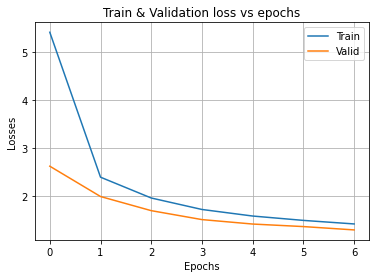

In [14]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

# Cloudy - ConvGRU

## Return all layers = no / convGRU_layers = 2 / fc_layers = 2

In [21]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[4]

num_epochs = 10
learning_rate = 5e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_cloudy, datetimes_test_cloudy, images_trainval_cloudy, images_test_cloudy, 
                                                         pv_log_trainval_cloudy, pv_log_test_cloudy, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
cloudy_GRU_loss = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 8.049446686810109 valid loss: 5.7660072632602155 test loss: 6.671901147047022
epoch: 1 train loss: 5.098815981619957 valid loss: 4.28552772798162 test loss: 5.315142468166644
epoch: 2 train loss: 4.275874776951222 valid loss: 3.7717134767167164 test loss: 4.4236151791521126
epoch: 3 train loss: 3.8509821597251386 valid loss: 3.4115238466089908 test loss: 3.9675471780469036
epoch: 4 train loss: 3.5708479691641912 valid loss: 3.5196961513839544 test loss: 3.9501727076031217
epoch: 5 train loss: 3.4335459425667945 valid loss: 3.527995393005798 test loss: 3.9540684067609813
epoch: 6 train loss: 3.4202658320855903 valid loss: 3.172909412271604 test loss: 3.7089775151924558
epoch: 7 train loss: 3.2127583124833197 valid loss: 2.959482047475506 test loss: 3.5745410296423685
epoch: 8 train loss: 3.0832731298662104 valid loss: 2.923178486206318 test loss: 3.5518645346635638
epoch: 9 train loss: 3.014583647707563 valid loss: 3.033361373526911 test loss: 3.684730229971863
spli

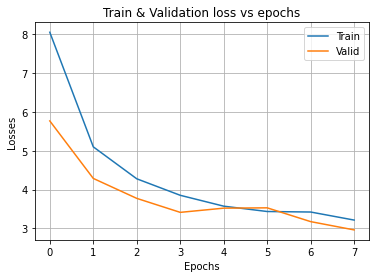

In [22]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

# Overcast - ConvGRU

## Return all layers = yes / convGRU_layers = 1 / fc_layers = 1

In [17]:
seq_len = 2
num_epochs = 30
learning_rate = 5e-5
weight_decay = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU2(conv_layers=0, convGRU_layers = 1, fc_layers = 1).to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_overcast, datetimes_test_overcast, images_trainval_overcast, images_test_overcast, 
                                                         pv_log_trainval_overcast, pv_log_test_overcast, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 2 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
overcast_GRU_loss = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 5.759943556614271 valid loss: 4.309294446790929 test loss: 4.886639264343886
epoch: 1 train loss: 3.7063455419479934 valid loss: 3.348048920232573 test loss: 3.524888880632624
epoch: 2 train loss: 3.3335602704837624 valid loss: 3.0814175217675928 test loss: 2.9264711564785535
epoch: 3 train loss: 3.115158214420681 valid loss: 2.958242907602138 test loss: 2.911998122043664
epoch: 4 train loss: 2.9399825838475055 valid loss: 2.854323475082746 test loss: 2.873709738065942
epoch: 5 train loss: 2.8487880428176333 valid loss: 2.768364358041793 test loss: 2.858025558128609
epoch: 6 train loss: 2.7244737326154373 valid loss: 2.6661270256795015 test loss: 2.6894886802607103
epoch: 7 train loss: 2.627295862911441 valid loss: 2.5638089714482155 test loss: 2.6086767614727946
epoch: 8 train loss: 2.5212687895028147 valid loss: 2.5169163794013882 test loss: 2.4985276812143193
epoch: 9 train loss: 2.418899584822714 valid loss: 2.489112471004559 test loss: 2.851877282692698
epoch:

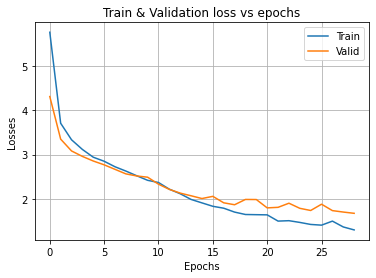

In [18]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

# Final Overall GRU

In [19]:
#overcast_GRU_loss = 1.6817722782882316
#cloudy_GRU_loss = 3.5056907896302443
#sunny_GRU_loss = 1.2862557947656448

In [23]:
overall_loss = len(images_test_sunny)*sunny_GRU_loss**2 + len(images_test_cloudy)*cloudy_GRU_loss**2 + len(images_test_overcast)*overcast_GRU_loss**2
overall_loss = overall_loss / (len(images_test_overcast) + len(images_test_sunny) + len(images_test_cloudy))
overall_loss = math.sqrt(overall_loss)
overall_loss

2.2654281716224607